# Building a Song Recommendation System Using Spotify API
In this project, I will be building a song recommendation system using the Spotify API. The Spotify API provides a wealth of information about songs, artists, albums, and users. I will be using the Spotipy library to access the Spotify API. The goal of this project is to take a user's login info and generate song recommendations by accessing their liked playlist. 

# 1. Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import spotipy
import plotly.express as px
from dotenv import load_dotenv
from spotipy.oauth2 import SpotifyOAuth, SpotifyClientCredentials
from sklearn.pipeline import Pipeline

# 2. Sourcing the Data by Artist
Rather than relying upon a pre-existing csv, I will be using the Spotify API to source the data. This attempts to query random artists by letter from Spotify then appends the results to a CSV file. 



In [2]:
# load the environment variables
load_dotenv()

# initialize the credentials from the environment variables
client_id = os.getenv('CLIENT_ID')
client_secret = os.getenv('CLIENT_SECRET')

# Authenticate with Spotify using Spotipy
auth_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(auth_manager=auth_manager)

# Function to fetch random artists by a random letter
def get_random_artists(limit):
    letter = random.choice('abcdefghijklmnopqrstuvwxyz')
    results = sp.search(q=f'{letter}*', type='artist', limit=limit)
    return results['artists']['items']

# Function to fetch top tracks for an artist
def get_top_tracks_for_artist(artist_id, limit):
    results = sp.artist_top_tracks(artist_id)
    tracks = results['tracks'][:limit]  # Limit the number of tracks to 20
    return tracks

# Function to fetch audio features for a list of track IDs
def get_audio_features(track_ids):
    features = sp.audio_features(tracks=track_ids)
    return features

# Main function to fetch random artists, their songs, and audio features
def get_songs_and_features_for_random_artists(num_artists=50, songs_per_artist=30):
    # Fetch a list of random artists
    artists = get_random_artists(limit=num_artists)
    
    # List to store all the songs with audio features
    all_songs = []

    # Fetch top tracks for each artist and their audio features
    for artist in artists:
        artist_name = artist['name']
        artist_id = artist['id']
        
        # Fetch top tracks for the artist
        top_tracks = get_top_tracks_for_artist(artist_id, limit=songs_per_artist)
        
        # Collect track IDs for audio features
        track_ids = [track['id'] for track in top_tracks]

        # Fetch audio features for the tracks
        audio_features = get_audio_features(track_ids)

        # Add each song's details and audio features to the list
        for track, features in zip(top_tracks, audio_features):
            if features:  # Check if features are available
                all_songs.append({
                    'Artist': artist_name,
                    'Song': track['name'],
                    'Track ID': track['id'],
                    'Album': track['album']['name'],
                    'Release Date': track['album']['release_date'],
                    'Popularity': track['popularity'],
                    'Danceability': features['danceability'],
                    'Energy': features['energy'],
                    'Loudness': features['loudness'],
                    'Speechiness': features['speechiness'],
                    'Acousticness': features['acousticness'],
                    'Instrumentalness': features['instrumentalness'],
                    'Liveness': features['liveness'],
                    'Valence': features['valence'],
                    'Tempo': features['tempo']
                })

    # Convert the list of songs and audio features to a DataFrame
    song_df = pd.DataFrame(all_songs)

    return song_df

# Execute the main function
song_df = get_songs_and_features_for_random_artists()

# Display the DataFrame
song_df.head()


Max Retries reached


SpotifyException: http status: 429, code:-1 - /v1/audio-features/?ids=5UGAXwbA17bUC0K9uquGY2,30QR0ndUdiiMQMA9g1PGCm,240audWazVjwvwh7XwfSZE,09riz9pAPJyYYDVynE5xxY,0kEZlJh4mK1QRfb3CT5LPk,6tO5bxNnMuh1c3cziSpecA,19n8izXThARSuQAXrOKNbO,1d966178PJg6b4kcXqoYF3,6QFQqqYye5lAcnhCALvxKJ,1tm7c4V0kqLiN0XPVnoUcT:
 Max Retries, reason: too many 429 error responses

# 3. Append Results to CSV
Taking the results from the previous step, while checking for duplicates to prevent redundancy in model training.

In [82]:
# Define path to the CSV file
csv_file = 'data/songs_with_features.csv'

# check if the file exists
if os.path.exists(csv_file):
    # Load the existing data
    existing_data = pd.read_csv(csv_file)
    # Append the new data
    updated_data = pd.concat([existing_data, song_df], ignore_index=True)
    # Drop duplicates
    updated_data = updated_data.drop_duplicates(subset='Track ID')
    # Save the updated data
    updated_data.to_csv(csv_file, index=False)
    print(f"Data appended to '{csv_file}'")
else:
    # Save the new data
    song_df.to_csv(csv_file, index=False)
    print(f"Data saved to '{csv_file}'")

Data appended to 'data/songs_with_features.csv'


# 4. Accessing a User's Playlists
This block returns the user's recent liked songs by accessing the Spotify API. This will act as input for the recommendation system. 

In [114]:
import os
import spotipy
from spotipy.oauth2 import SpotifyOAuth

# Initialize redirect uri from dashboard
redirect_uri = 'http://localhost:5000/callback'

# Authenticate with Spotify using OAuth
sp_oauth = SpotifyOAuth(client_id=client_id, 
                        client_secret=client_secret, 
                        redirect_uri=redirect_uri,
                        scope="user-library-read")

sp = spotipy.Spotify(auth_manager=sp_oauth)

# Get the current user's saved tracks
tracks = sp.current_user_saved_tracks(limit=50)

# Extract track IDs and artist names for each track
track_ids = [item['track']['id'] for item in tracks['items']]
top_tracks = [item['track'] for item in tracks['items']]

# Get the audio features for these tracks
audio_features = sp.audio_features(track_ids)

# List to hold all songs and their features
all_songs = []

# Add each song's details and audio features to the list
for track, features in zip(top_tracks, audio_features):
    if features:  # Check if features are available
        all_songs.append({
            'Artist': track['artists'][0]['name'],
            'Song': track['name'],
            'Track ID': track['id'],
            'Album': track['album']['name'],
            'Release Date': track['album']['release_date'],
            'Popularity': track['popularity'],
            'Danceability': features['danceability'],
            'Energy': features['energy'],
            'Loudness': features['loudness'],
            'Speechiness': features['speechiness'],
            'Acousticness': features['acousticness'],
            'Instrumentalness': features['instrumentalness'],
            'Liveness': features['liveness'],
            'Valence': features['valence'],
            'Tempo': features['tempo']
        })

# Create a DataFrame from the list of dictionaries
df_tracks = pd.DataFrame(all_songs)
print(df_tracks.head())

# write the data to a csv file
df_tracks.to_csv('data/user_tracks_with_features.csv', index=False)

Max Retries reached


SpotifyException: http status: 429, code:-1 - /v1/audio-features/?ids=1mUTpDe3E8pML637zOFL5D,7hR22TOX3RorxJPcsz5Wbo,0BCPKOYdS2jbQ8iyB56Zns,0uRrG2jRR5tuifsYIJHEao,4ZJ4vzLQekI0WntDbanNC7,2dono2Koz7DEvGwxUsmMLq,1fXiYSWmkKJfRKMegCkI11,42lqBjPYlmL1EXpMDXvhSN,6or1bKJiZ06IlK0vFvY75k,58kdQwsAi2zHEiU2l0CBB8,4EoKbid1MFccC0VCtO5ehz,4wt2PBgqXZbvRiWSHDc4O4,6jXPZid0KLorvgIDP6TiSo,24uwABPWPejBuvFL4tMkvD,2HbpYFQbairMoU2YFyOP2x,5ZLzl6T8JwqMTMdoE0nCbU,4DpBfWl3q8e0gGB76lAaox,6PrKZUXJPmBiobMN44yR8Y,6HdieikOXlB5C75iebDKqp,3HL9dtbUo5mJwXQyaEUESR,0rRboI6IRuGx56Dq3UdYY4,1ACZpHI5vZ5Ea4xGlkdGWM,131yybV7A3TmC34a0qE8u8,1Bw7kDeY4ZPfUo5UY18tOO,03Yv8adIIOsRACDHLUYS9l,62HyVeSK4fpxjKj6dsI5MP,6DyywdbmTzlmXBzG9ym7Rt,2bfwYcc1FzkIym0XRkYb7F,6keueqJqlA0VEKLyKdUQRA,2dbOYFfS7r7NAzquRvji9A,4nva9EpKntUTs6CRSGBCn9,41uRcFai0Ta90sBnYB4OgK,5LyRtsQLhcXmy50VXhQXXS,5a2hIQWInPjqkkFiUEgxoX,3nPUPTVGhcRStUxcvM5xtI,44ARj4IaCoOevEu1oy0z1v,4ePx4Js87KSIVMLL4RD7vX,7nnWIPM5hwE3DaUBkvOIpy,5xpG6EQnL4AEkivmbERHbY,6lFpfxcxgNo9srWkRuk9ZM,7qEUFOVcxRI19tbT68JcYK,5ubHAQtKuFfiG4FXfLP804,5DOYik1z3Of1wAFfY3dYbC,0JXXNGljqupsJaZsgSbMZV,2plbrEY59IikOBgBGLjaoe,4z5L0qDduw3w1apQ4Qa6KV,36wAwEkSDpNQ4oQeRLYC3L,748yv6bb3l3CcKS45a6SZ8,7oAZVxmRCVFanxK7tk16vv,1k2pQc5i348DCHwbn5KTdc:
 Max Retries, reason: too many 429 error responses

# 5. Data Visualization and Exploratory Data Analysis

## 5.1 Correlation with Popularity

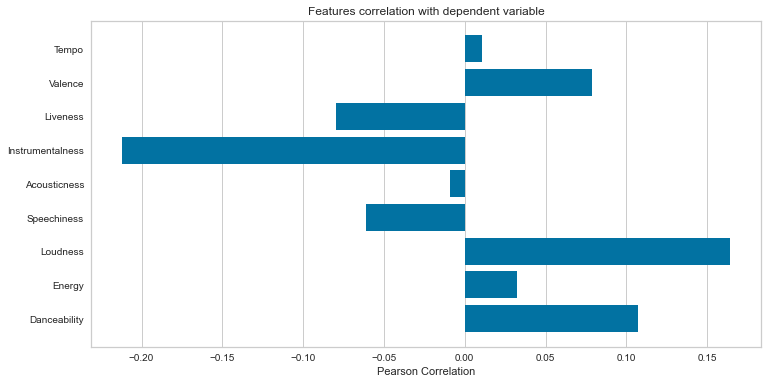

<AxesSubplot: title={'center': 'Features correlation with dependent variable'}, xlabel='Pearson Correlation'>

In [83]:
# exploring the correlation between audio features and popularity
from yellowbrick.target import FeatureCorrelation

# Data from songs_with_features.csv
data = pd.read_csv('data/songs_with_features.csv')

# define features and target
feature_names = ['Danceability', 'Energy', 'Loudness', 'Speechiness', 'Acousticness', 
                 'Instrumentalness', 'Liveness', 'Valence', 'Tempo']

X, y = data[feature_names], data['Popularity']

# Create a list of the feature names
features = np.array(feature_names)

# Instantiate the visualizer
visualizer = FeatureCorrelation(labels=features)

plt.rcParams['figure.figsize']=(12,6)
visualizer.fit(X, y)     # Fit the data to the visualizer
visualizer.show()

The Pearson correlation coefficient is a measure of the strength and direction of a linear relationship between two variables. The value of the correlation coefficient ranges from -1 to 1. A value of 1 indicates a perfect positive linear relationship, -1 indicates a perfect negative linear relationship, and 0 indicates no linear relationship between the two variables. Instrumentalness indicates a weak negative correlation with popularity, while Loudness has a very weak positive correlation with popularity.

## 5.2 Features Over Time

In [84]:
# Data from songs_with_features.csv
data = pd.read_csv('data/songs_with_features.csv')

# add a new column for the year
data['Year'] = pd.to_datetime(data['Release Date']).dt.year

# Group the data by year and calculate the mean of each feature
features_by_year = data.groupby('Year').mean().reset_index()

# audio features to plot
sound_features = feature_names = ['Danceability', 'Energy', 'Speechiness', 'Acousticness', 
                 'Instrumentalness', 'Liveness', 'Valence']

# interactive plot using Plotly
fig = px.line(features_by_year, x='Year', y=sound_features)
fig.show()


Most of the audio features have remained relatively stable over time. However, there is a noticeable decline in the acousticness of songs over the years. This suggests that modern music tends to have less acoustic elements compared to older music.

# 6. Clustering Songs
Clustering songs based on their audio features using K-Means clustering. This will help in identifying groups of songs that are similar to each other.

## 6.1 Tuning the Number of Clusters: Elbow Method
The Elbow Method is a technique that helps decide how many clusters to use by plotting the inertia against the number of clusters and identifying a point where the rate of decrease slows down (the "elbow").

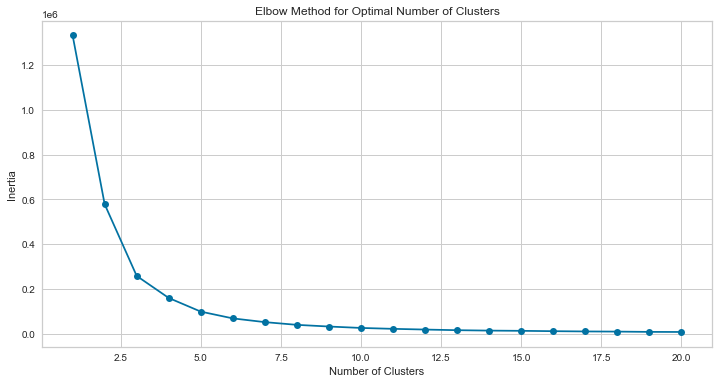

In [85]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def elbow_method(X, max_clusters=20):
    inertia = []
    cluster_range = range(1, max_clusters + 1)
    for k in cluster_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        inertia.append(kmeans.inertia_)

    # Plot inertia vs. number of clusters
    plt.plot(cluster_range, inertia, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal Number of Clusters')
    plt.show()

# Call the elbow method
X = data[feature_names + ['Popularity']]
elbow_method(X)

## 6.2 Tuning the Number of Clusters: Silhouette Score
The silhouette score measures how similar an object is to its own cluster (cohesion) compared to other clusters (separation). It ranges from -1 to 1, with higher values indicating well-defined clusters. 

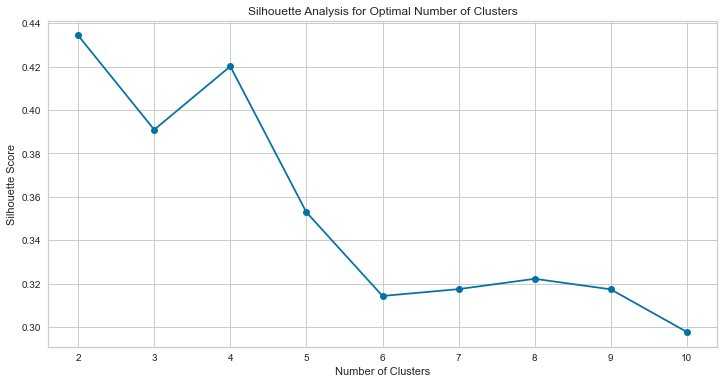

In [122]:
from sklearn.metrics import silhouette_score

def silhouette_analysis(X, max_clusters=10):
    scores = []
    for k in range(2, max_clusters+1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X)
        score = silhouette_score(X, labels)
        scores.append(score)
        
    # Plot silhouette scores
    plt.plot(range(2, max_clusters+1), scores, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score for Optimal Number of Clusters')
    plt.show()

silhouette_analysis(X)

The silhouette score is highest when the number of clusters is 2, indicating that the data may be best represented by two clusters. However, the silhouette score is relatively low, suggesting that the data may not have clear clusters.

## 6.3 Clustering Pipeline
Building a clustering pipeline using K-Means clustering to group songs based on their audio features. Also using Isolation Forest to remove outliers before clustering. This is to prevent cluster imbalance and ensure that the clusters are meaningful.

In [123]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import plotly.express as px

# Define your feature names (the columns used for clustering)
feature_names = ['Danceability', 'Energy', 'Loudness', 'Speechiness', 
                 'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo']

# X as the feature names and popularity column
X = data[feature_names + ['Popularity']]

# Step 1: Use IsolationForest to remove outliers
iso_forest = IsolationForest(contamination=0.05, random_state=42)  # Adjust contamination level as needed
outliers = iso_forest.fit_predict(X)

# Keep only inliers (outliers == 1)
X_cleaned = X[outliers == 1]
data_cleaned = data[outliers == 1].reset_index(drop=True)  # Keep only inliers in the data

# Step 2: Define the MiniBatchKMeans clustering pipeline
song_cluster_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('kmeans', MiniBatchKMeans(n_clusters=2, random_state=42))
])

# Fit the pipeline on the cleaned data
song_cluster_pipeline.fit(X_cleaned)
song_cluster_labels = song_cluster_pipeline.predict(X_cleaned)

# Add cluster labels to the cleaned data
data_cleaned['cluster_label'] = song_cluster_labels

# Step 3: PCA for dimensionality reduction and visualization
pca_pipeline = Pipeline([('scaler', StandardScaler()), ('PCA', PCA(n_components=2))])
song_embedding = pca_pipeline.fit_transform(X_cleaned)

# Create a DataFrame for projection
projection = pd.DataFrame(columns=['x', 'y'], data=song_embedding)
projection['title'] = data_cleaned['Song']
projection['cluster'] = data_cleaned['cluster_label']

# Step 4: Plot the clusters using Plotly
fig = px.scatter(
    projection, x='x', y='y', color='cluster', hover_data=['x', 'y', 'title'])
fig.show()


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but IsolationForest was fitted with feature names



# 8. Song Recommendation
Calculating the Euclidean distance between the new songs and each cluster's centroid to determine the closest cluster.

In [125]:
from sklearn.metrics import pairwise_distances_argmin_min

def get_cluster_for_new_song(new_songs_df, song_cluster_pipeline, feature_names):
    # Extract features from new songs
    X_new = new_songs_df[feature_names + ['Popularity']]

    # Get the KMeans model from the pipeline
    kmeans_model = song_cluster_pipeline.named_steps['kmeans']

    # Extract centroids from the KMeans model
    centroids = kmeans_model.cluster_centers_

    # Calculate the Euclidean distance between new songs and each cluster's centroid
    closest, distances = pairwise_distances_argmin_min(X_new, centroids)

    # Add the closest cluster and distance information to the new songs DataFrame
    new_songs_df['closest_cluster'] = closest
    new_songs_df['distance_to_centroid'] = distances

    return new_songs_df

# Get the closest cluster and distances for each new song
new_songs_df = pd.read_csv('data/user_tracks_with_features.csv')
quantitative_clusters_df = get_cluster_for_new_song(new_songs_df, song_cluster_pipeline, feature_names)

# Show the new songs with their closest cluster and distance to the centroid
print(quantitative_clusters_df[['Song', 'closest_cluster', 'distance_to_centroid']])

                                                 Song  closest_cluster  \
0                                   Talkin' Tennessee                1   
1                                       Love Somebody                1   
2                                              Clocks                1   
3                                    Sand In My Boots                1   
4                                          Pink Skies                1   
5                           Linger - SiriusXM Session                1   
6                                         I Will Wait                1   
7                                  Somebody’s Problem                1   
8                                             Rap God                1   
9                                  What Would You Say                1   
10                     More Fool Me - 2007 Stereo Mix                1   
11                                           The Ride                1   
12                           God's Gon

# 9. Conclusion
In this project, I built a song recommendation system using the Spotify API. I sourced data from Spotify, used PCA to reduce dimensionality, and clustered songs using K-Means. I then used the Euclidean distance to determine the closest cluster for new songs.

The recommendation system assigned each new song to the same cluster. This suggests that the new songs are similar to each other in terms of their audio features. It is possible that there is some clustering bias in the model, and further tuning may be required to improve the recommendations. Adding more songs and features to the model could also help improve the accuracy of the recommendations.